In [1]:
# See the paper for differences between the available versions of BigGAN
# https://arxiv.org/abs/1809.11096

# module_path = 'https://tfhub.dev/deepmind/biggan-deep-128/1'  # 128x128 BigGAN-deep
# module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1'  # 256x256 BigGAN-deep
module_path = 'https://tfhub.dev/deepmind/biggan-deep-512/1'    # 512x512 BigGAN-deep
# module_path = 'https://tfhub.dev/deepmind/biggan-128/2'       # 128x128 BigGAN
# module_path = 'https://tfhub.dev/deepmind/biggan-256/2'       # 256x256 BigGAN
# module_path = 'https://tfhub.dev/deepmind/biggan-512/2'       # 512x512 BigGAN

In [2]:
import io

import numpy as np
import pandas as pd

import PIL.Image
import IPython.display

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

from utils import *

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Run this cell to configure Tensorflow to use your GPU
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
module = hub.Module(module_path)

inputs = {
    k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
    for k, v in module.get_input_info_dict().items()
}

output = module(inputs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
# Tensor z holds the random noise for each image to be generated.
noise_in = inputs['z']
dim_noise = noise_in.shape.as_list()[1]

# Tensor y is the one-hot-encoded class for each image to be generated.
class_in = inputs['y']
dim_class = class_in.shape.as_list()[1]

# Scalar between 0 and 1 that is the truncation factor of the noise.
trunc_in = inputs['truncation']

{n: t.shape for n, t in inputs.items()}

{'y': TensorShape([Dimension(None), Dimension(1000)]),
 'z': TensorShape([Dimension(None), Dimension(128)]),
 'truncation': TensorShape([])}

In [6]:
output

<tf.Tensor 'module_apply_default/G_trunc_output:0' shape=(?, 512, 512, 3) dtype=float32>

In [7]:
sess = tf.Session()

initializer = tf.global_variables_initializer()
sess.run(initializer)

In [8]:
import json

def get_classes():
    """
    Returns a Pandas Series, where values are class labels and the index consists of class IDs.
    """
    with open('./biggan_classes.json') as f:
        classes = json.loads(f.read())
    classes = [c.split(') ')[1] for c in classes]
    classes = pd.Series(classes)
    return classes

classes = get_classes()
classes.sample(10)

44           alligator lizard
572                    goblet
884                     vault
469         caldron, cauldron
556    fire screen, fireguard
956             custard apple
511               convertible
144                   pelican
800    slot, one-armed bandit
546           electric guitar
dtype: object

In [9]:
# See docs: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder

# Creates a one-hot-encoder with the same dimension as the number of classes.
# Then fits it to map [3] -> [[0, 0, 1]], and so on.

class_encoder = OneHotEncoder(categories='auto')
class_encoder.fit(np.arange(dim_class).reshape(-1, 1))

OneHotEncoder()

In [10]:
def class_labels_to_ids(class_labels):
    """
    Converts an iterable of class labels into Numpy array of class IDs.
    
    Expected global variable: classes
    """
    return np.array([(classes == c).idxmax() for c in class_labels])


def class_ids_to_one_hot(class_ids):
    """
    Converts a 1-d array of class IDs into 2-d array of one-hot-encoded classes.
    
    Expected global variable: classes
    """
    class_ids = class_ids.reshape(-1, 1)
    class_ohs = class_encoder.transform(class_ids)
    return class_ohs.toarray()


def random_classes(batch_size=20, seed=41):
    """
    Returns a 2-d array of random classes in one-hot format.
    
    Expected global variable: classes
    """
    class_labels = classes.sample(batch_size, random_state=seed)
    class_ids = class_labels_to_ids(class_labels)
    class_ohs = class_ids_to_one_hot(class_ids)
    return class_ohs

In [11]:
random_classes(batch_size=20).shape

(20, 1000)

In [12]:
# See docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
from scipy.stats import truncnorm

def random_noise(batch_size=10, truncation_factor=1, truncation_threshold=2, seed=100):
    """
    Returns a 2-d array of random noise.
    
    Normal distribution with mean = 0 and std = 1 is truncated to
    range defined as [-threshold * factor, threshold * factor].
    """
    state = np.random.RandomState(seed)
    
    random_z = truncnorm.rvs(
        -truncation_threshold * truncation_factor, 
        truncation_threshold * truncation_factor, 
        size=(batch_size, dim_noise), 
        random_state=state
    )
    
    return random_z

In [13]:
random_noise(batch_size=20).shape

(20, 128)

In [14]:
def generate_images(classes, noises, truncation_factor, batch_size=10):
    """
    Generates the images from given model inputs.
    100 of 512x512 images take ~2 minutes on 8-core CPU.
    
    Computation is performed in batches to avoid running out of RAM.
    Note that the required RAM is an affine function of the batch size.
    From empirical evidence, batch size of 5 with 512x512 images will use ~10GB RAM.
    
    Note that all images are generated with the same truncation factor.
    
    Expected global variables: sess, output
    """
    
    # Count of images to be generated.
    n = classes.shape[0]

    # Indexes of the first image to be generated in each batch.
    starts = np.arange(0, n, batch_size)
    
    outputs = []
    for start in starts:
        batch_idx = slice(start, start+batch_size)
            
        feed_dict = {
            noise_in: noises[batch_idx], 
            class_in: classes[batch_idx], 
            trunc_in: truncation_factor
        }

        outputs.append(sess.run(output, feed_dict=feed_dict))
        
    outputs = np.concatenate(outputs)
    
    # Rescales from floats in [-1, 1] to ints in [0, 255].
    images = ((outputs + 1) * 127).astype('uint')
    
    return images

In [15]:
sample_size = 25

truncation_factor = 1
random_z = random_noise(sample_size, truncation_factor=truncation_factor)

class_id = class_labels_to_ids(['mushroom'])
class_oh = class_ids_to_one_hot(class_id)
class_oh = np.repeat(class_oh, sample_size, axis=0)

random_z.shape, class_oh.shape

((25, 128), (25, 1000))

CPU times: user 14.5 s, sys: 18.1 s, total: 32.6 s
Wall time: 48.1 s


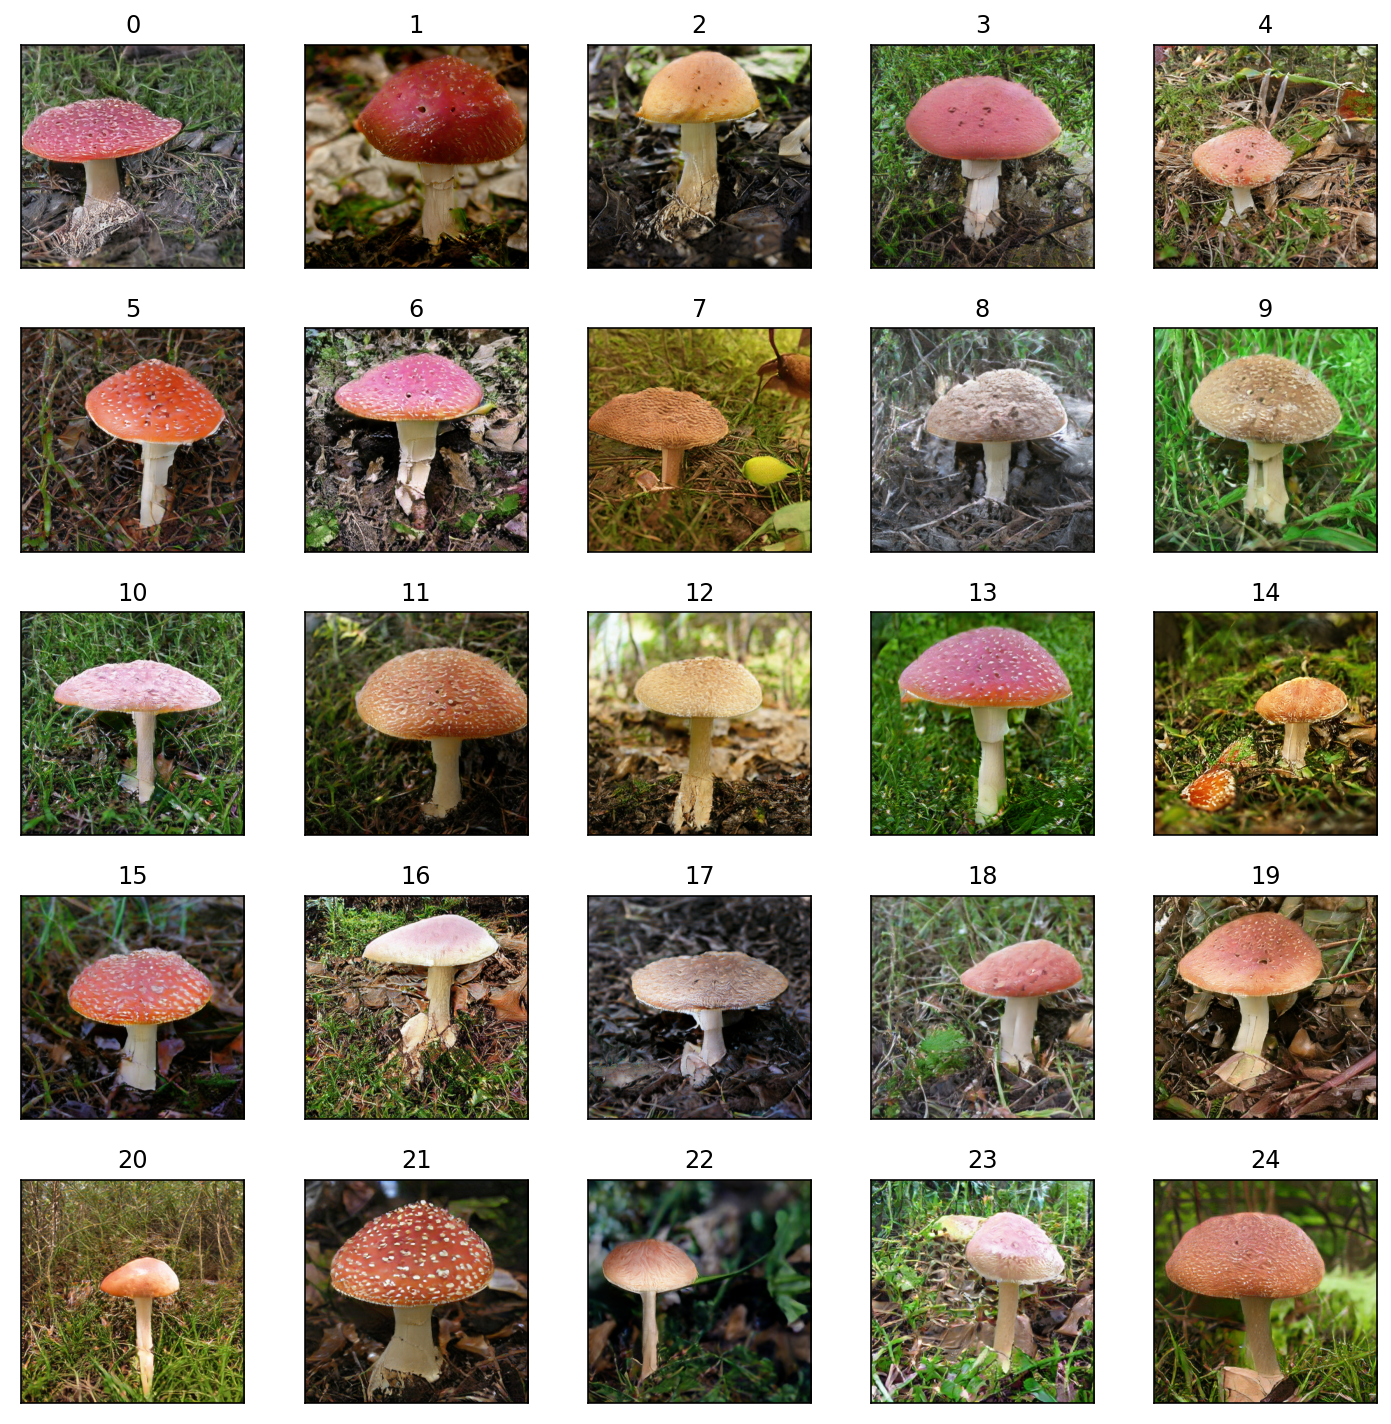

In [16]:
%%time

images = generate_images(class_oh, random_z, truncation_factor, batch_size=1)
plot_strided_grid(images, ncols=5, nrows=5)

In [17]:
def interpolate_classes(start_class, end_class, batch_size):
    """
    Returns a batch of class vectors interpolated between the start and the end class.
    """
    weights = np.linspace(0, 1, batch_size)
    pair_cls = [start_class, end_class]

    pair_ids = class_labels_to_ids(pair_cls)
    pair_oh = class_ids_to_one_hot(pair_ids)
    pair_int = [
        pair_oh[1] * r + pair_oh[0] * (1-r) 
        for r in weights
    ]
    
    class_oh = np.array(pair_int)
    return class_oh


steps = 200

class_oh = interpolate_classes(
#      'steam locomotive',
    'Rottweiler',
#     'iPod',
#     'ice cream, icecream',
    'jaguar, panther, Panthera onca, Felis onca',
#     'golfcart, golf cart',
    batch_size=steps,
)

truncation_factor = 0.0001
random_z = random_noise(batch_size=1, truncation_factor=truncation_factor)
random_z = np.repeat(random_z, steps).reshape(steps, dim_noise)

random_z.shape, class_oh.shape

((200, 128), (200, 1000))

CPU times: user 26.8 s, sys: 12.1 s, total: 38.9 s
Wall time: 34.9 s


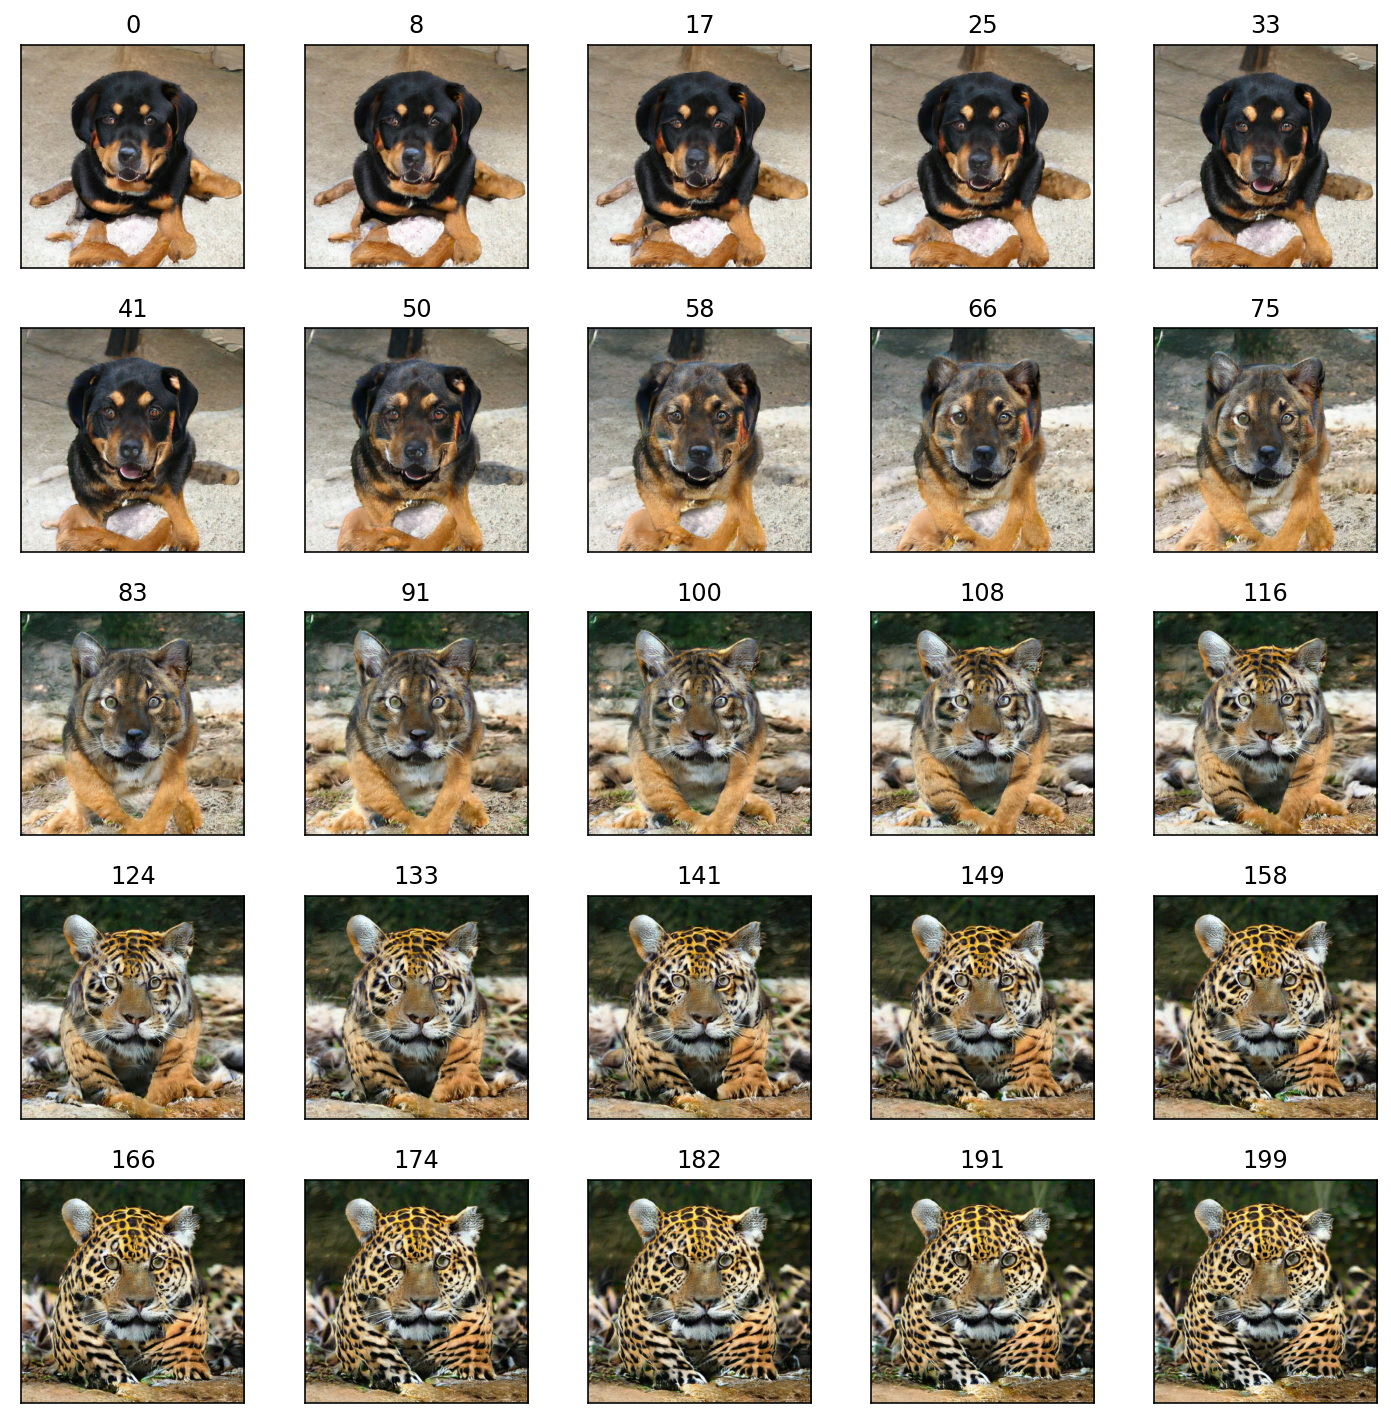

In [18]:
%%time

images = generate_images(class_oh, random_z, truncation_factor, batch_size=1)
plot_strided_grid(images)

In [19]:
import subprocess

folder = save_images(images, 'interclass')
subprocess.run(['../gif.sh', folder], check=True)
print(f'The animation has been saved to {folder}/output.gif')

Images are saved to interclass4
The animation has been saved to interclass4/output.gif


In [20]:
%%html
<img src="./rottweiler_panthera.gif">